# White Matter Tracts and Laterality Over a Lifespan

## Introduction

Many researchers have investigated the microstructural changes of the white matter throughout a lifespan of humans, however, not many investigate on lateralization changes of those white matter tissues. One of the goals of this project is to create data visualization to illustrate the microstructural properties of white matter in major tracts as it deferens crosssectionally across the brain through human life span.

**What is White Matter?** The two primary tissue types in the human brain are  white matter and the gray matter. Both types of tissues deliver different functions. In this study, researchers will focus on the white matter. The white matter are tissues that contain primarily the axons of neurons and glial cells, which acts as the channels of **communication**, essentially, coordinating communication between the different brain regions. Meanwhile, the gray matter are tissues that contain neuronal cell bodies allow individuals to control movement, memory recollection, and emotions. 

The white matter tracts were expected to be distinguished by the different age groups of the participants: child (3 - 12 years old), adult (20 - 39 years old), middle ages (40 - 59 years old), and senior (60 - 86 years old). In this study, the fractional anisotropy (FA), a scalar value that describes the degree of anisotropy of a diffusion process in the brain, was used to measure laterality in human white matter tracts. The FA values of the white matter were measured by using diffusion magnetic resonance imaging (dMRI) because white matter is microscostructure, which can only be visible and examined with a microscope. dMRI uses a magnetic field to track and show the diffusion of water in the brain, which results in a different pattern of signal loss or the dark areas of the image because of the anisotropic diffusion.escent (13 - 19 years old), adult (20 - 39 years old), middle ages (40 - 59 years old), and senior (60 - 86 years old). 

In [1]:
# Importing all the libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch
from sklearn.linear_model import LinearRegression

In [2]:
# read in the data
df = pd.read_csv('laterality_data.csv')

In [3]:
# check in on data
df.head()

,Match Flag,subjectID,Data,Order_FA_child,Order_volume_child,Order_MD_child,structureID,gender,gender_non,Age_gr_12,...,LI MD,LI Volume,TOI,Control,category,hand,Hand,ROI 1,ROI 2,Type
0,3,P1158,PING,AnterioFrontoCerebellar,AnterioFrontoCerebellar,AnterioFrontoCerebellar,AnterioFrontoCerebellar,0,M,0-12,...,0.015758,-0.068848,no,no,Cerebellar,NaN,NaN,Frontal,Cerebellum,Projection
1,3,P1158,PING,Arc,Arc,Arc,Arc,0,M,0-12,...,NaN,0.167642,no,yes,Language,NaN,NaN,Frontal,Temporal,Association
2,3,P1158,PING,Aslant,Aslant,Aslant,Aslant,0,M,0-12,...,NaN,0.010843,yes,no,Vertical,NaN,NaN,Frontal,Frontal,Association
3,3,P1158,PING,CST,CST,CST,CST,0,M,0-12,...,0.002403,-0.012036,no,no,Motor,NaN,NaN,Medulla,Motor Cortex,Projection
4,3,P1158,PING,ContraAnterioFrontoCerebellar,ContraAnterioFrontoCerebellar,ContraAnterioFrontoCerebellar,ContraAnterioFrontoCerebellar,0,M,0-12,...,-0.014053,-0.066723,no,no,Cerebellar,NaN,NaN,Frontal,Cerebellum,Projection


In [4]:
df.count()

Match Flag            44648
subjectID             44648
Data                  44648
Order_FA_child        44648
Order_volume_child    44648
Order_MD_child        44648
structureID           44648
gender                44648
gender_non            44648
Age_gr_12             44648
Age Group             44648
Age                   44648
LI FA                 41241
LI MD                 41272
LI Volume             41040
TOI                   44648
Control               44648
category              44648
hand                  43510
Hand                  43390
ROI 1                 44648
ROI 2                 44648
Type                  44648
dtype: int64

In [5]:
# Counting the number of NA values in the dataset.
na_column = pd.DataFrame()
for column in df:
    new_row = {'Column': column, 'NA Count': df[column].isna().sum()}
    na_column = na_column.append(new_row, ignore_index=True)
na_column

,Column,NA Count
0,Match Flag,0.0
1,subjectID,0.0
2,Data,0.0
3,Order_FA_child,0.0
4,Order_volume_child,0.0
5,Order_MD_child,0.0
6,structureID,0.0
7,gender,0.0
8,gender_non,0.0
9,Age_gr_12,0.0


As it can be seen above, excluding the variables we are interested in (LI FA, LI MD, LI Volume), only the hand data has missing data. Due to this, we have to exclude them from the calculation as they are not important to the research question we are interested in.

In [6]:
# Rereating new DataFrame without Hand data b/c they not necessary.
cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,21]
df = df[df.columns[cols]]

In [7]:
# dropping all NA's or missing data
df.dropna(how = 'any', inplace = True)
# Checking the number of data points again.
df['LI FA'].count()

35595

By deleting the hand data and dropping all the missing values, I can now focus on the data that is important to the question of laterality. This data processing dropped my original dataset (counting up to 44,000) all the way down to 35,595 datapoints that we can focus on.

# Creating the Heat and Cluster Maps!

After doing the data processing, I now need to create a pivot table that will be inputted into a clustermap so that the data can be clearly visualized. The columns will be the age groups while the rows (observations) will be the different regions of the brain we are interested in.

In [8]:
# Creating Pivot Table for necessary organization of data that will be inputed into heat and clustermaps!

heatmap_data_before = pd.pivot_table(df, values='LI FA',
                             index=['Order_FA_child'], # White Matter Tracts Ordered by LI
                             columns='Age Group')
heatmap_data_before.dropna(inplace=True) # Just in case if there are any missing datapoints after averaging the data in pivot.
heatmap_data_before.index.names = ['Regions of the Brain'] # Renaming variable so that it makes more sense.
 
heatmap_data_before

Age Group,Adolescent,Adult,Child,Middle Age,Senior
Regions of the Brain,,,,,
AnterioFrontoCerebellar,0.006964,0.016402,-0.001383,0.016785,0.021505
Arc,0.016139,0.037126,0.012195,0.019770,0.023055
Aslant,0.011315,0.028006,0.000708,0.034851,0.037006
Baum,0.014359,0.024711,0.023192,0.008768,0.009876
CST,0.002886,0.004251,0.006231,0.019092,0.023247
Cingulum,0.029806,0.037872,0.044103,0.036011,0.044806
ContraAnterioFrontoCerebellar,0.006286,0.012841,-0.006652,0.009957,0.009697
ContraMotorCerebellar,0.008918,0.006284,0.004558,0.008201,0.011467
FrontoThalamic,-0.002189,0.030870,-0.005601,0.015037,0.021139


From looking at the table above, the age groups are not in order. This could potentially be a problem whenever we do visualize the data in the clustermap. As a result, we have to reorder the age-groups. The order will be: Child, Adolescent, Adult, Middle Age, and Senior.

Age Group,Child,Adolescent,Adult,Middle Age,Senior
Regions of the Brain,,,,,
VOF,-0.018077,-0.011164,0.004098,-0.018606,-0.020809
TPC,0.004251,-0.006322,0.007219,-0.014014,-0.013789
pArc,0.023684,0.002622,0.013367,-0.015102,-0.018122
Cingulum,0.044103,0.029806,0.037872,0.036011,0.044806
TemporoThalamic,0.037120,0.035227,0.005653,0.045973,0.048452
SLF1And2,-0.013393,-0.006229,-0.012393,0.016021,0.026414
SLF3,-0.003349,0.022639,0.016379,0.043329,0.050418
Aslant,0.000708,0.011315,0.028006,0.034851,0.037006
OccipitoCerebellar,0.005166,0.013156,0.015518,0.032773,0.039261


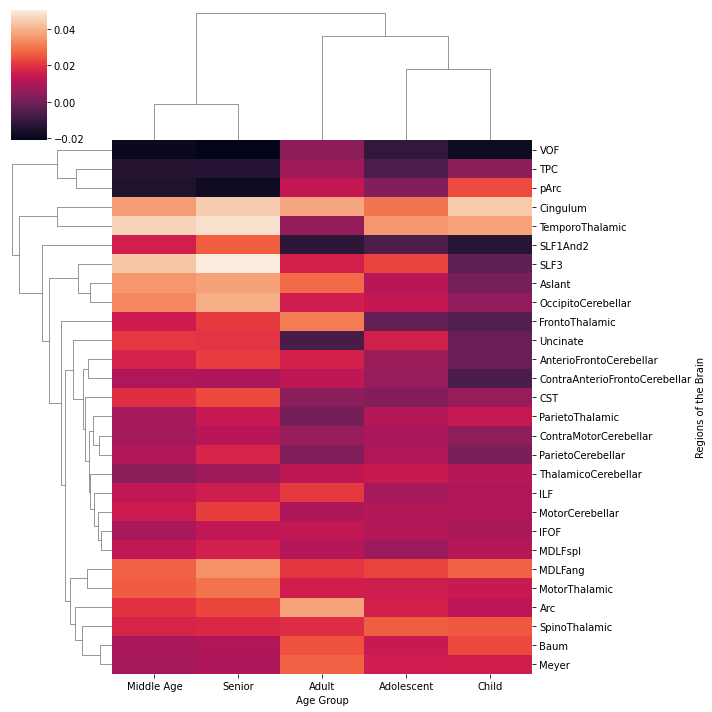

In [9]:
# Reorderinng the clustermap!

area_clustermap = sns.clustermap(heatmap_data_before); # Creating the clustermap for reordering

# set the desired order of groups
age_groups = ['Child', 'Adolescent', 'Adult', 'Middle Age', 'Senior'] 

# reorder indexes/indices besed on the desired order
new_order = []
for age in age_groups:
    inds = area_clustermap.data2d.columns.str.startswith(age)
    inds_locs = np.where(inds)[0].tolist()
    new_order += inds_locs
    
## reorder df based on the new order
ordered_df_area = area_clustermap.data2d.iloc[:, new_order]

ordered_df_area


With the data reordered, I now need to create a clustermap that is visually appealing for the viewer and easy to understand. This means having a legend that has 0.00 and values above and below that value so that people understand where the laterality is occuring. Left lateralization means negative FA values while right lateralization means positive FA values. Furthermore, we need to use the ward hierarchial clustering method as that mimizes within-cluster variance as much as possible.

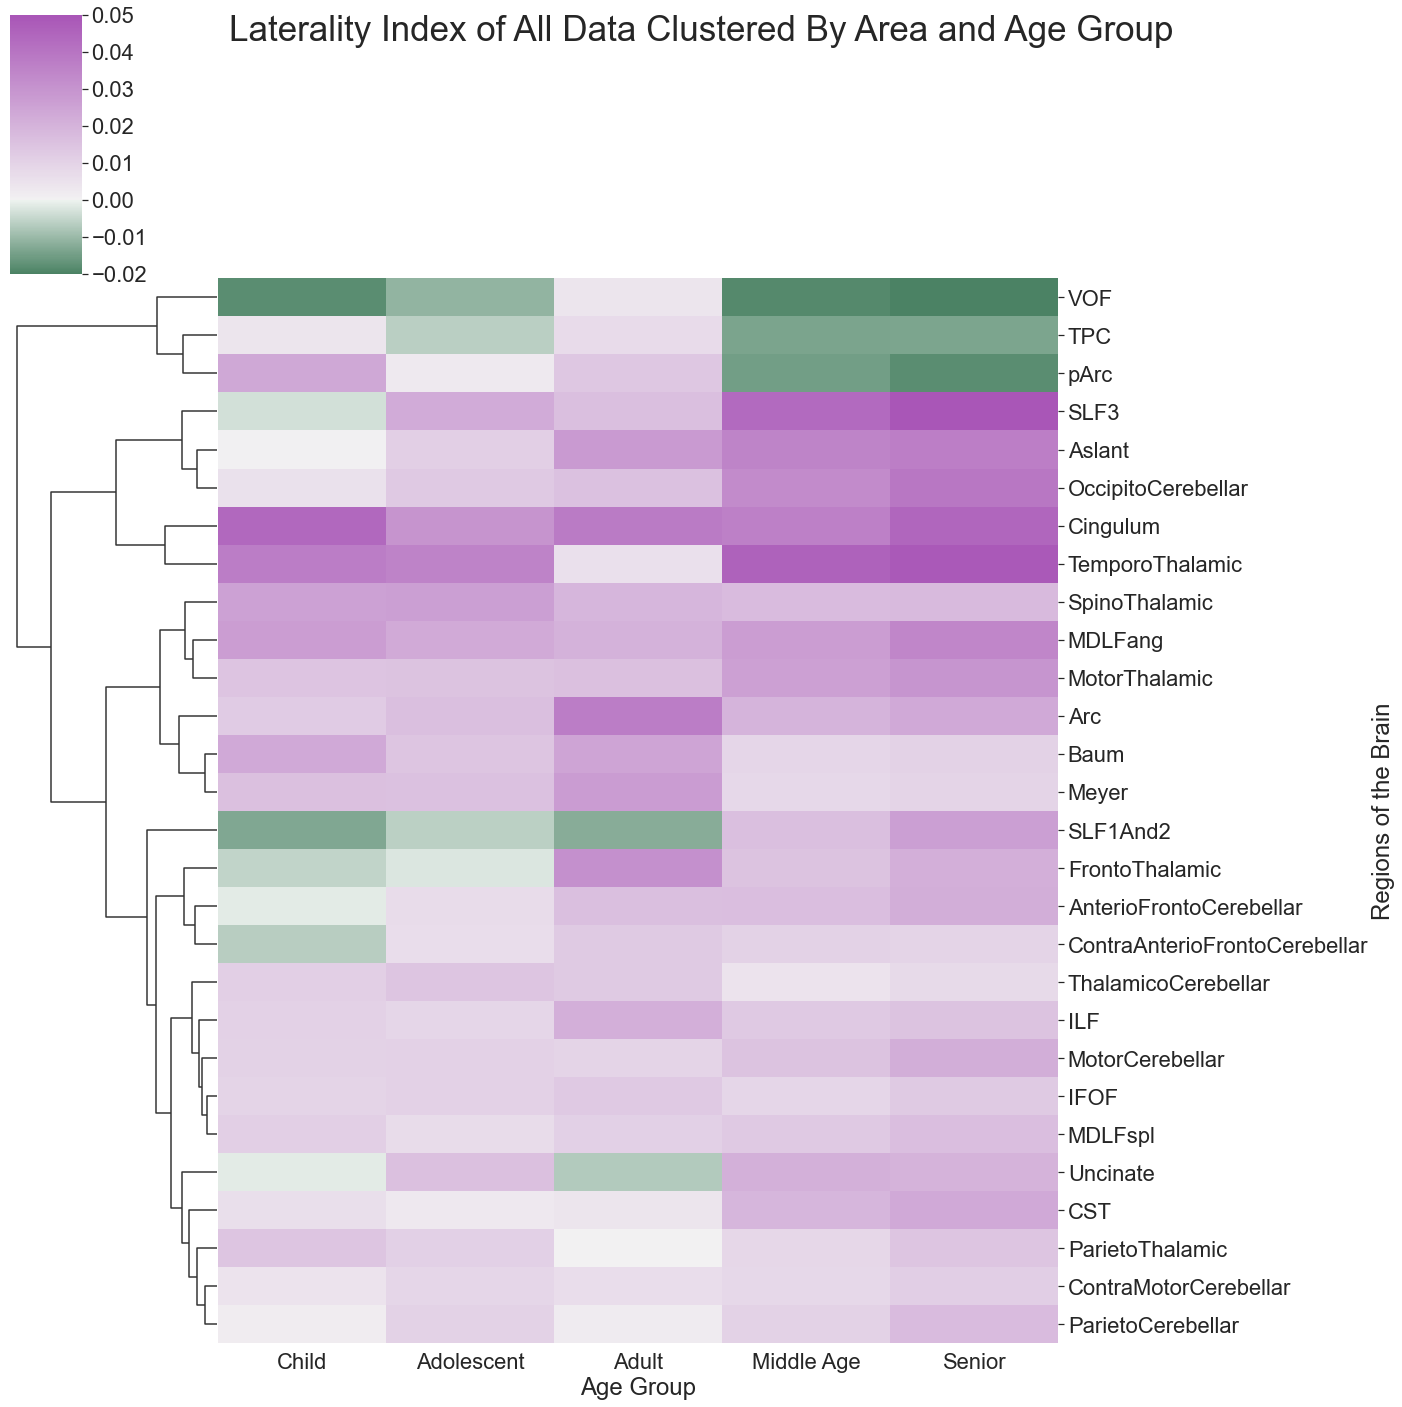

In [10]:

vcenter = 0 #Creating the center for all the datapoints.
vmin, vmax = -0.02, 0.05 # max and min values from graph below
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax) # normalizing the data around that point.
colormap = sns.diverging_palette(145, 300, s=60, as_cmap=True) # creating color map for the clustermap.

## Run clustermap.
sns.set(font_scale = 2)




g = sns.clustermap(ordered_df_area,
              figsize=(20,20),
              row_cluster=True,
              col_cluster=False,
              norm = normalize,
              method = 'ward',
              tree_kws= dict(linewidths=1.5),
              cmap=colormap).fig.suptitle('Laterality Index of All Data Clustered By Area and Age Group', 
                                       fontsize =35) 
fig = g.get_figure()



From the clustermap above, it can be concluded that there are clear clusters being created. For example, VOF, TPC, and pArc have laterality indeces that are very similar throughout a human lifespan. Now that the clusters are made, we need to take a deeper dive into each cluster to come to a greater conclusion on the laterality.

# Creating Parallel Plots of the Clusters

In order to create the parallel plots, the data had to be transposed so that the pivot table could be inputted correctly into the *lineplot* function. If we keep the data in the same order, the lineplot function will not run as the function registers the x-values as the regions of the brain rather than the age groups. This will make lineplots that are messy and hard to read.

In [11]:
transposed  = ordered_df_area.T

<AxesSubplot:ylabel='VOF'>

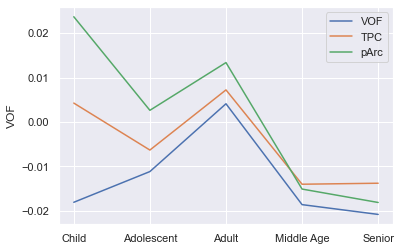

In [12]:
# first cluster
sns.set(font_scale = 1) # Fixing the font so leters are easier to read
sns.lineplot(data=transposed,  x = ['Child', 'Adolescent', 'Adult','Middle Age','Senior'], y = 'VOF', label = 'VOF')
sns.lineplot(data=transposed,  x = ['Child', 'Adolescent', 'Adult','Middle Age','Senior'], y = 'TPC', label = 'TPC')
sns.lineplot(data=transposed,  x = ['Child', 'Adolescent', 'Adult','Middle Age','Senior'], y = 'pArc', label = 'pArc')


As it can be seen above, the lines follow a simialr pattern to one another, indicating that there is a pattern among these regiosn of the brain.

### Exclaimer!

Rather than writing this same line code each time for each cluster, it would be better to write a function that takes in each cluster and maps it out!

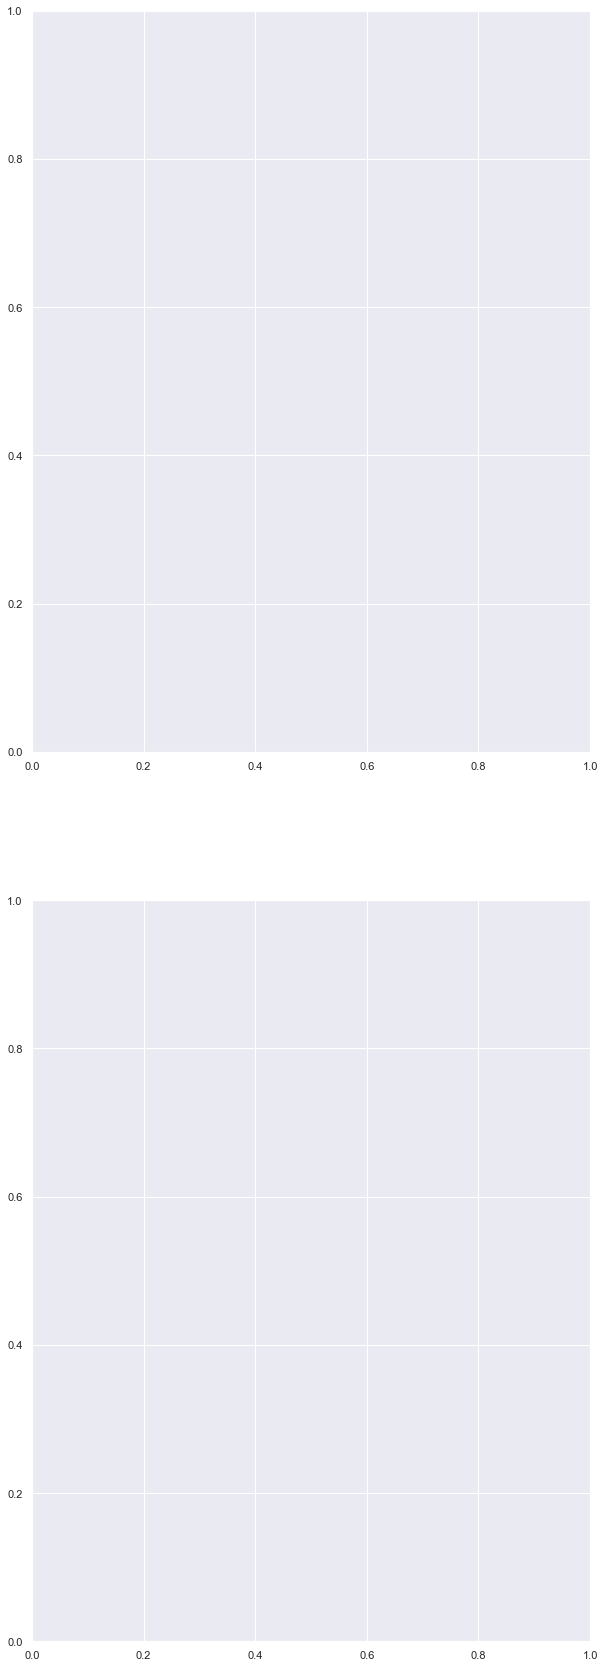

In [16]:
fig1, ax1 = plt.subplots(2, 1, figsize=(10, 30))

def lineplot_cluster(data, cluster = [], ax_index = ax1, axes = 0, title = '', linecolor = [], linewidth = 5,
                    title_fontsize = 20, facecolor = 'white', ylab = '', ysize = 10,
                    ticksx = 30, ticksy = 50, legend_size = 30, fig = fig1):
    # iterating through each cluster and creating the lineplot.
    for i in range(len(cluster)): 
        sns.lineplot(data = data, x = ['Child', 'Adolescent', 'Adult', 'Middle Age', 'Senior'], y = cluster[i], 
                    label = cluster[i], color = linecolor[i],
                    lw = linewidth, ax = ax_index[axes])
    # Additional parameters that will help
    ax_index[axes].set_title(title, fontsize = title_fontsize)
    ax_index[axes].set_ylabel(ylab, fontsize= ysize)
    ax_index[axes].tick_params(axis='y', which='major', labelsize = ticksy)
    ax_index[axes].tick_params(axis='x', which='major', labelsize = ticksx)
    ax_index[axes].set_facecolor(facecolor)
    ax_index[axes].legend(fontsize = legend_size)
    
    return fig
    
        

**Now that I have written the function, it is time to check out whether if it works properly or not!**

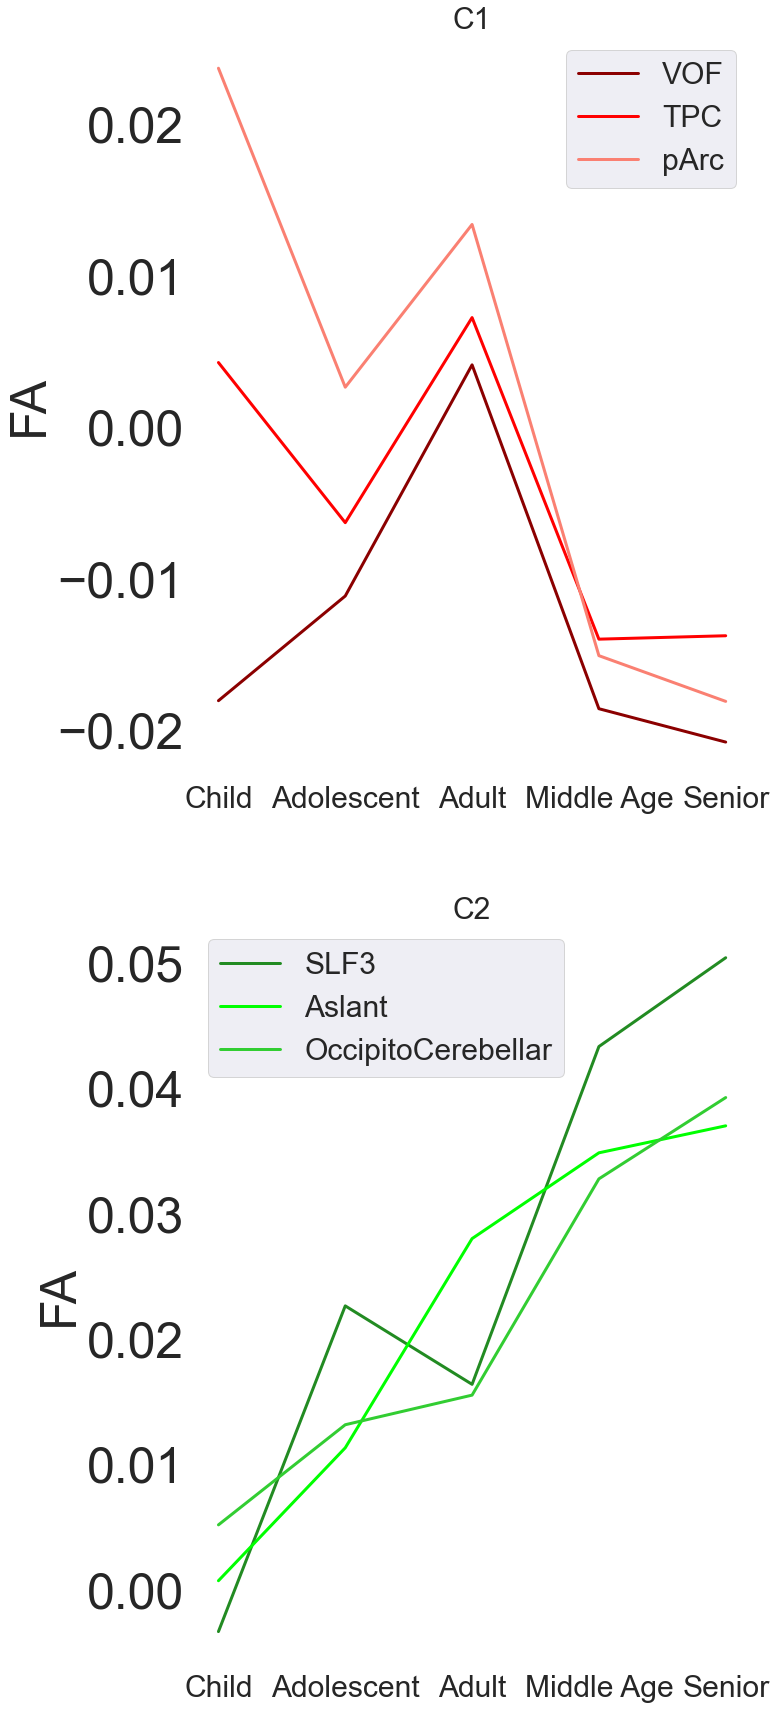

In [17]:
# First Cluster
first_cluster = ['VOF', 'TPC', 'pArc']
c1_col = ['darkred','red', 'salmon'] 
lineplot_cluster(data = transposed, cluster = first_cluster, ax_index = ax1, axes = 0, title = 'C1', linecolor = c1_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, 
                 legend_size = 30, fig = fig1)
# Second Cluster
c2 = ['SLF3', 'Aslant', 'OccipitoCerebellar']
c2_col = ['forestgreen', 'lime', 'limegreen']
lineplot_cluster(data = transposed, cluster = c2, ax_index = ax1, axes = 1, title = 'C2', linecolor = c2_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig1)

As it can be seen above, the function works perfectly. So, now we use it for all of the clusters and create one big graph!

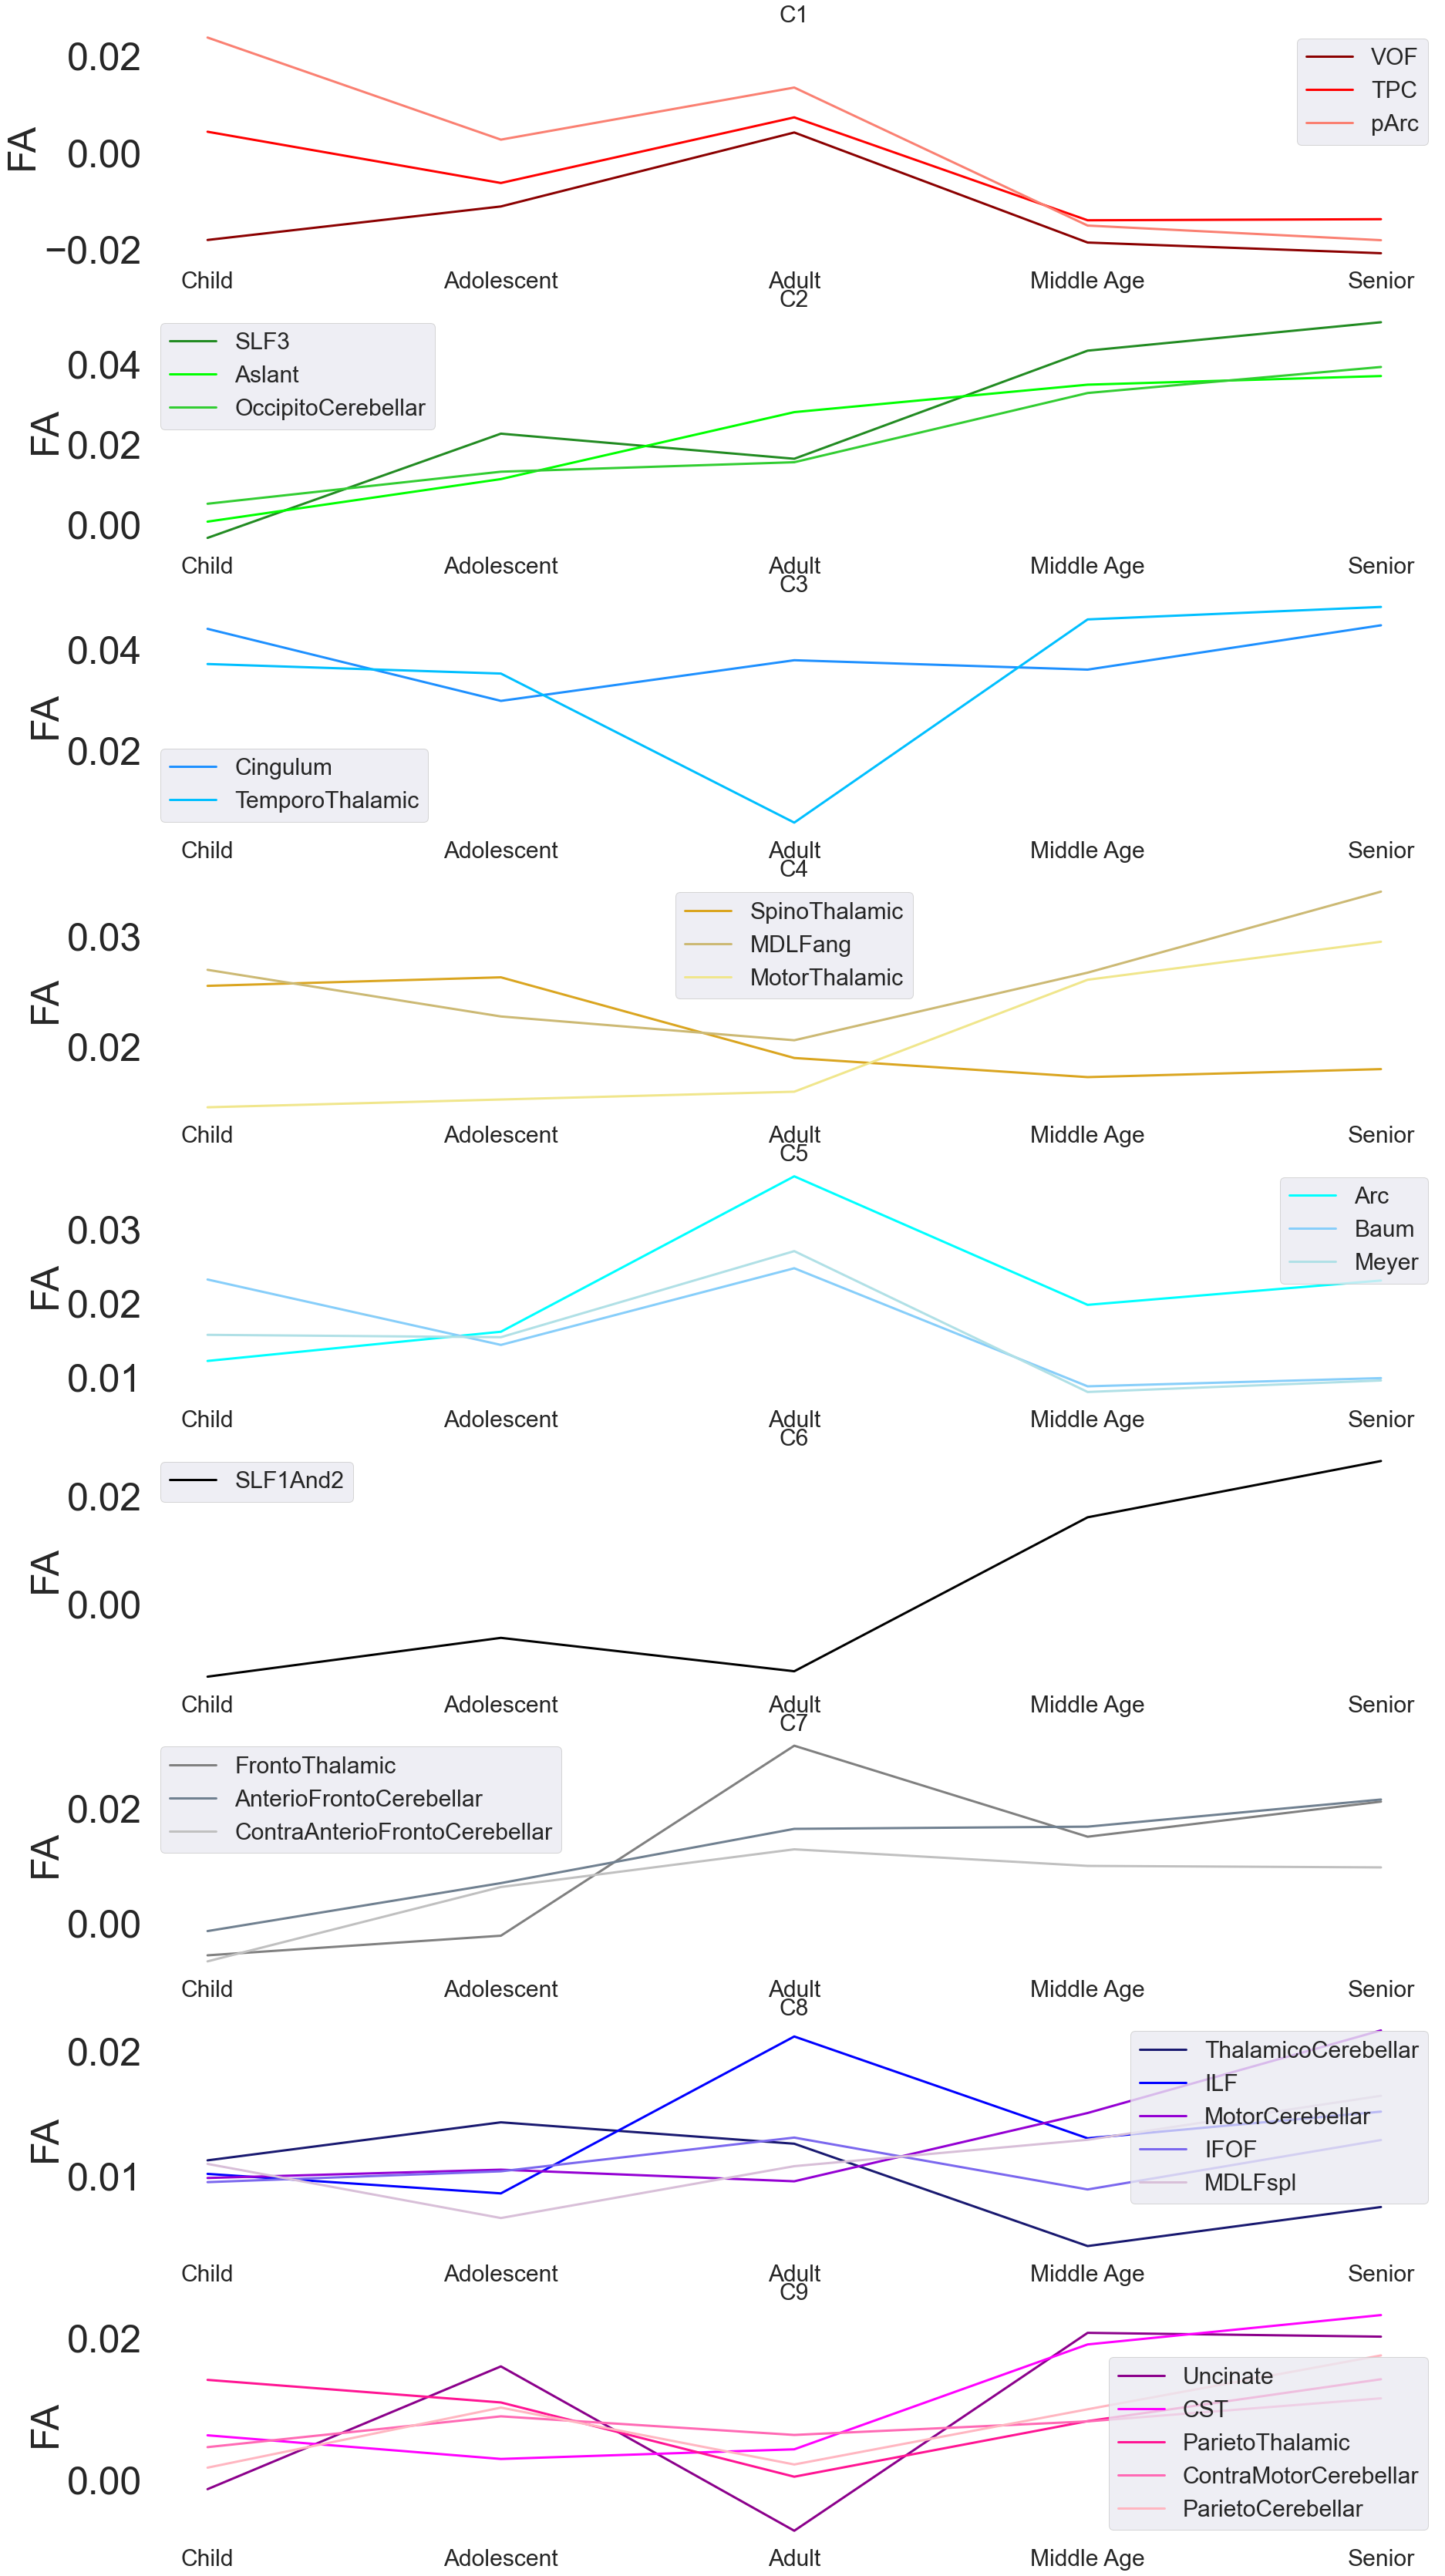

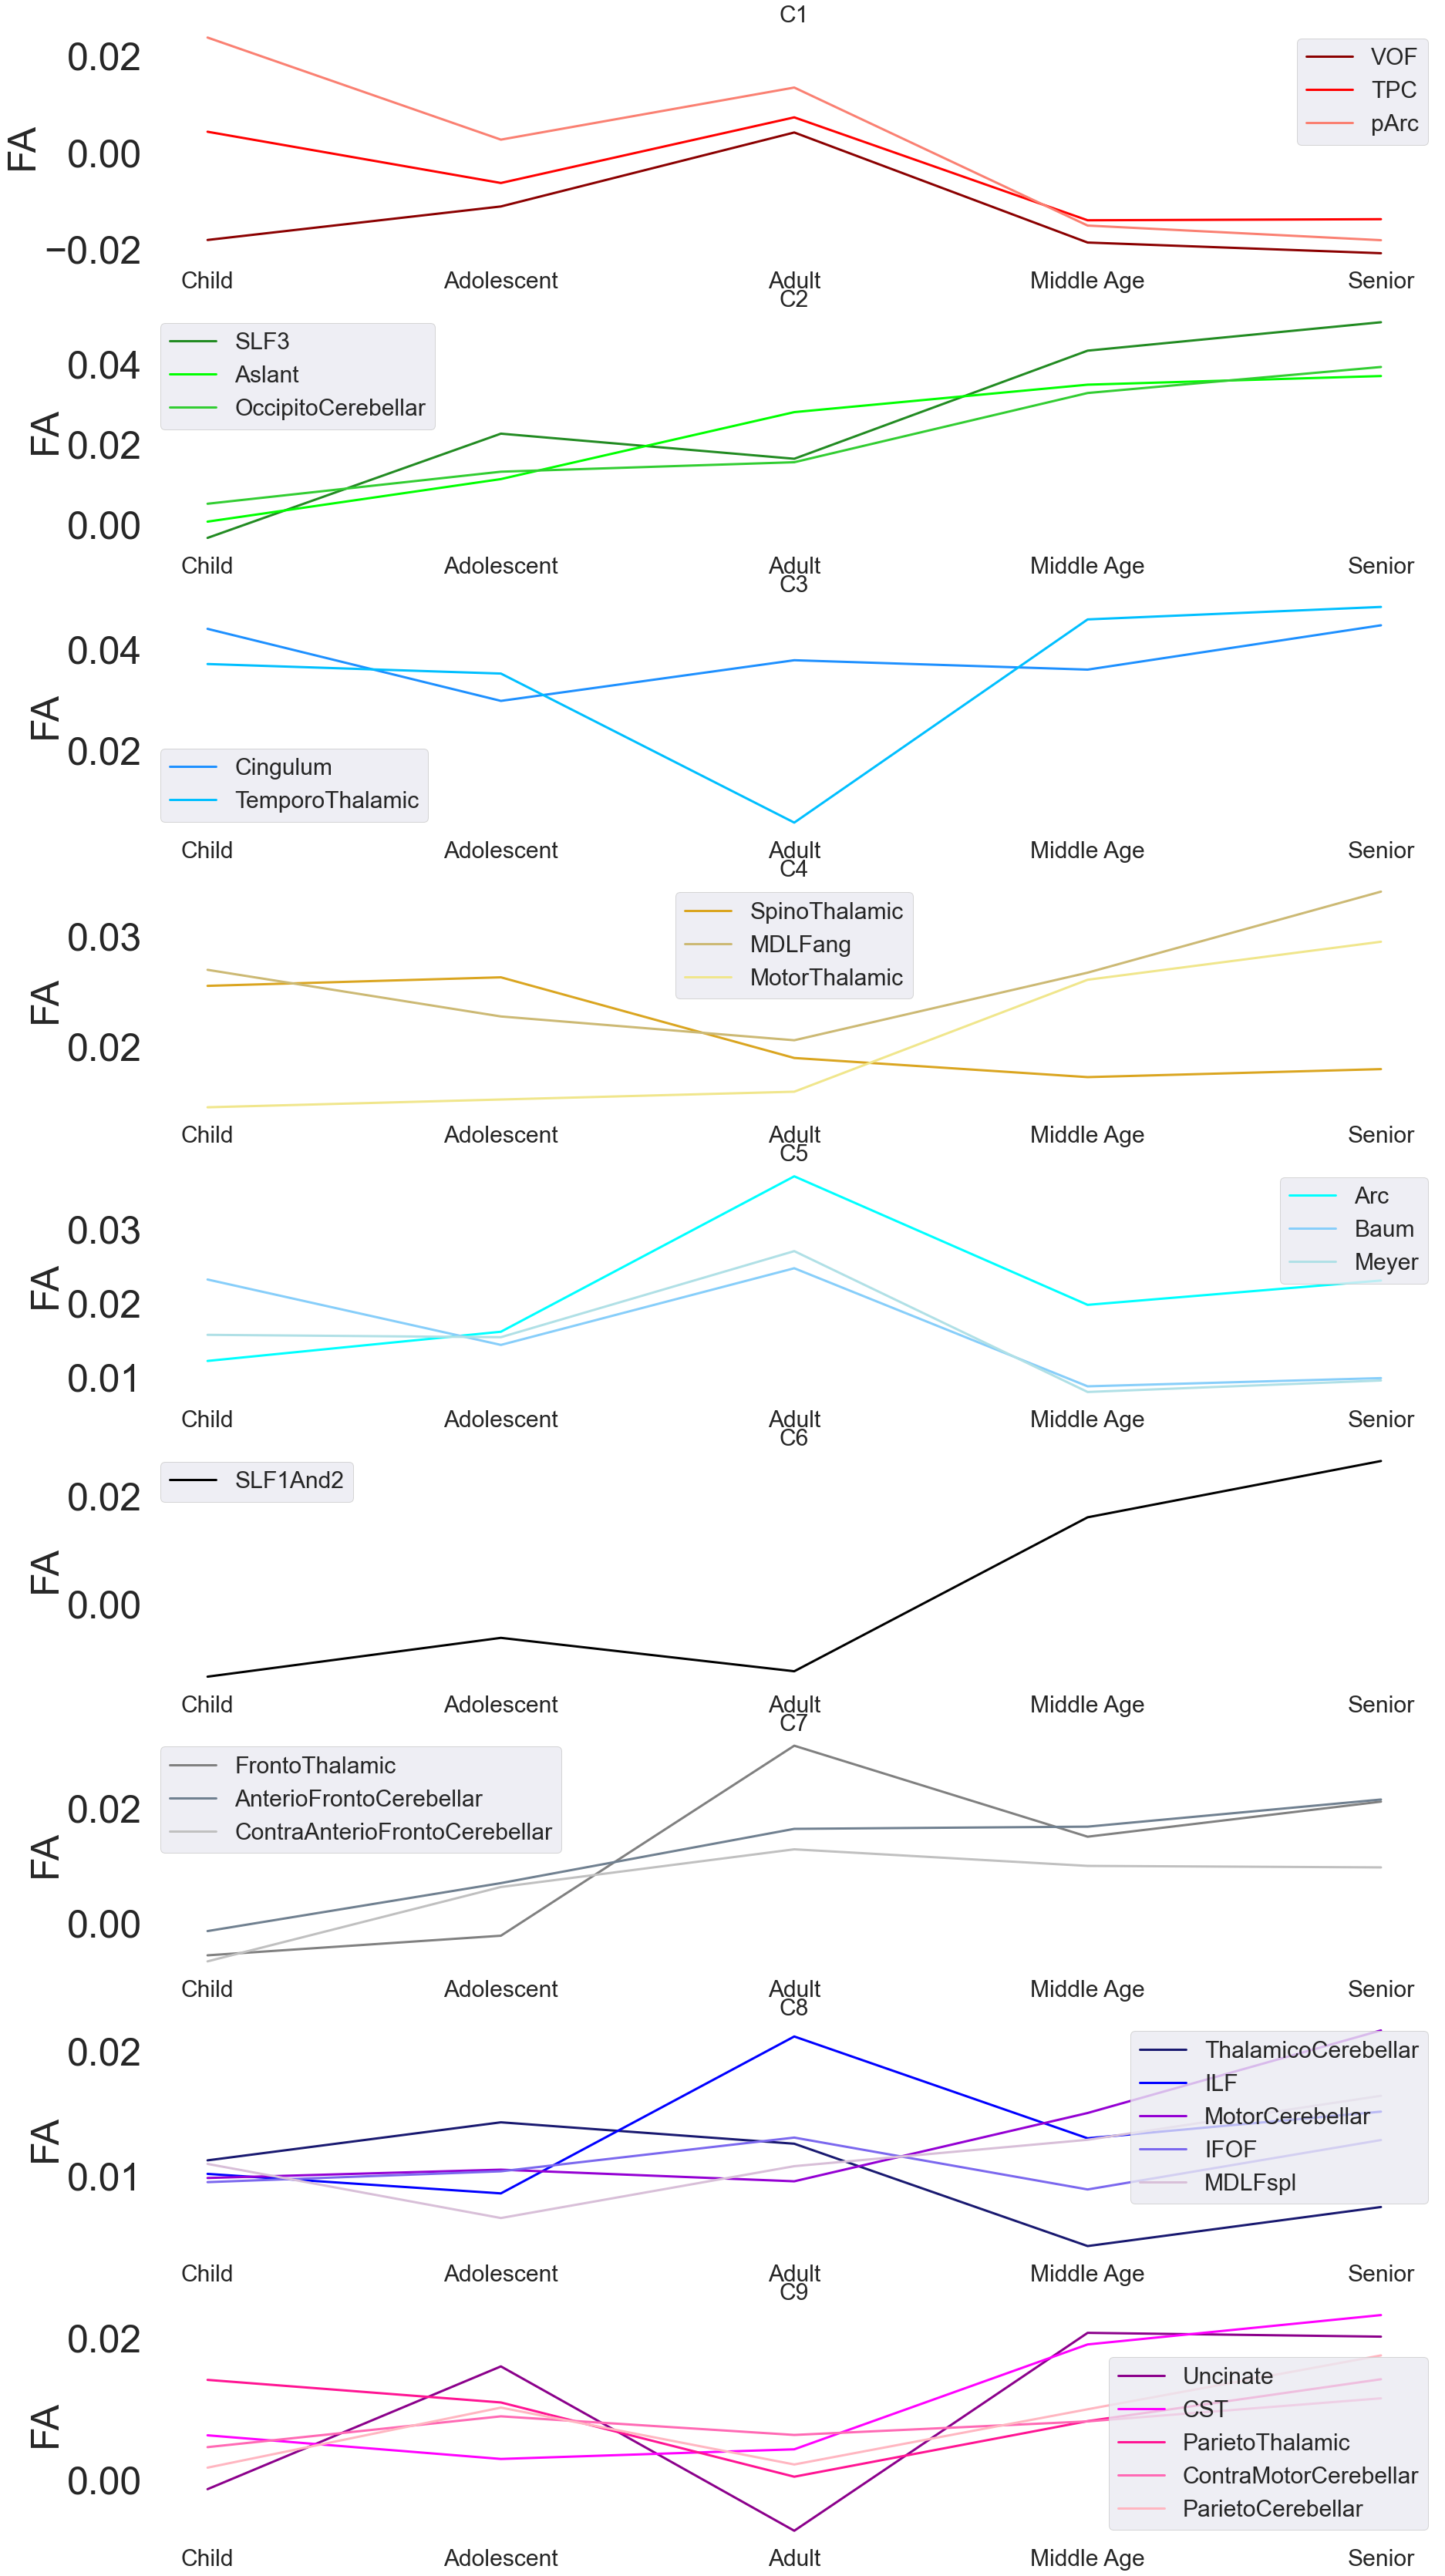

In [15]:
fig2, ax2 = plt.subplots(9, 1, figsize=(30, 60))

# first cluster
first_cluster = ['VOF', 'TPC', 'pArc']
c1_col = ['darkred','red', 'salmon'] 
lineplot_cluster(data = transposed, cluster = first_cluster, ax_index = ax2, axes = 0, title = 'C1', linecolor = c1_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Second Cluster
c2 = ['SLF3', 'Aslant', 'OccipitoCerebellar']
c2_col = ['forestgreen', 'lime', 'limegreen']
lineplot_cluster(data = transposed, cluster = c2, ax_index = ax2, axes = 1, title = 'C2', linecolor = c2_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Third Cluster
c3 = ['Cingulum', 'TemporoThalamic']
c3_col = ['dodgerblue', 'deepskyblue']
lineplot_cluster(data = transposed, cluster = c3, ax_index = ax2, axes = 2, title = 'C3', linecolor = c3_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Fourth Cluster
c4 = ['SpinoThalamic', 'MDLFang', 'MotorThalamic']
c4_col = ['goldenrod', 'y', 'khaki']
lineplot_cluster(data = transposed, cluster = c4, ax_index = ax2, axes = 3, title = 'C4', linecolor = c4_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Fifth Cluster
c5 = ['Arc', 'Baum', 'Meyer']
c5_col = ['aqua', 'lightskyblue','powderblue']
lineplot_cluster(data = transposed, cluster = c5, ax_index = ax2, axes = 4, title = 'C5', linecolor = c5_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Sixth Cluster
c6 = ['SLF1And2']
c6_col = ['black']
lineplot_cluster(data = transposed, cluster = c6, ax_index = ax2, axes = 5, title = 'C6', linecolor = c6_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Seventh Cluster
c7 = ['FrontoThalamic', 'AnterioFrontoCerebellar', 'ContraAnterioFrontoCerebellar']
c7_col = ['gray', 'slategray', 'silver']
lineplot_cluster(data = transposed, cluster = c7, ax_index = ax2, axes = 6, title = 'C7', linecolor = c7_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Eight Cluster

c8 = ['ThalamicoCerebellar', 'ILF', 'MotorCerebellar', 'IFOF', 'MDLFspl']
c8_col = ['midnightblue', 'blue', 'darkviolet', 'mediumslateblue', 'thistle']
lineplot_cluster(data = transposed, cluster = c8, ax_index = ax2, axes = 7, title = 'C8', linecolor = c8_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Ninth Cluster
c9 = ['Uncinate', 'CST', 'ParietoThalamic', 'ContraMotorCerebellar', 'ParietoCerebellar']
c9_col = ['darkmagenta', 'magenta', 'deeppink', 'hotpink', 'lightpink']
lineplot_cluster(data = transposed, cluster = c9, ax_index = ax2, axes = 8, title = 'C9', linecolor = c9_col, linewidth = 3,
                title_fontsize = 30, facecolor = 'white', ylab ='FA', ysize= 50, ticksx = 30, ticksy = 50, legend_size = 30, 
                 fig = fig2)

# Conclusion

The figure above once again proves that there indeed is some pattern in laterality for some of these clusters. For instance, clusters 1 and 5 have lateralities that are almost identical in pattern. So, even though this does not prove the reason why there are similarities amongst these white matter tracts, it does prove that there is something here to explore.